<a href="https://colab.research.google.com/github/KaterynaSiniuta/ML-Hillel/blob/main/HW_7_Class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**ДЗ 7. Дисбаланс класів**

Класифікація датсету

https://archive.ics.uci.edu/ml/datasets/glass+identification

Задача - усунення дисбалансу і перевірка впливу на точність моделі

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# We will use the Seaborn library
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


sns.set()

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

In [ ]:
datasets_path = "/content/drive/MyDrive/Colab Notebooks/glass+identification/"
glass = pd.read_csv(datasets_path + "glass.data")

glass.head()

,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00.1,1.1
0,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
1,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
2,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
3,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
4,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1


In [ ]:
# Проведемо первинний аналіз даних датасету скла
print("Загальний опис датасету:", glass.info(), "\n")
print(glass.isna().sum(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   1        213 non-null    int64  
 1   1.52101  213 non-null    float64
 2   13.64    213 non-null    float64
 3   4.49     213 non-null    float64
 4   1.10     213 non-null    float64
 5   71.78    213 non-null    float64
 6   0.06     213 non-null    float64
 7   8.75     213 non-null    float64
 8   0.00     213 non-null    float64
 9   0.00.1   213 non-null    float64
 10  1.1      213 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.4 KB
Загальний опис датасету: None 

1          0
1.52101    0
13.64      0
4.49       0
1.10       0
71.78      0
0.06       0
8.75       0
0.00       0
0.00.1     0
1.1        0
dtype: int64 



Датасет має 1 колонку ідентификатор та 9 фічей, що описують характеристики скла, та інт колонку тип скла. Саме тип скла і є таргетом. NaN значень в датасеті немає. додамо для зручності назви колонок

In [ ]:
names = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type"]
glass.columns = names

In [ ]:
# видаляємо id колонку

glass = glass.drop(columns=['Id'])

glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
1,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
2,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
3,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
4,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1


In [ ]:
# скільки записів якого значення type

print(glass['Type'].value_counts())

Type
2    76
1    69
7    29
3    17
5    13
6     9
Name: count, dtype: int64


датасет не є збалансованих, а 4 тип взагалі відсутній

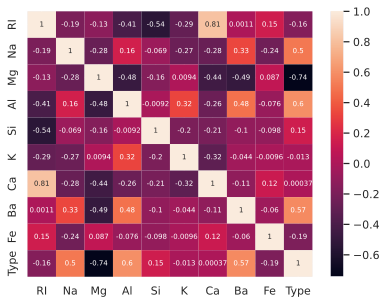

In [ ]:
# Побудуємо хітмап, щоб краще побачити які фічі і наскільки кореляюють між собою
corr_matrix = glass.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 7});

сильно корелюють між собою RI та CA. з цікавинок інтернету: Изменение плотности стекла
Введение в стекло оксидов металлов щелочноземельных элементов (включая кальций) повышает его плотность. Чем больше плотность, тем, как правило, выше показатель преломления, поскольку увеличивается количество «массы», взаимодействующей со светом на единицу объёма.

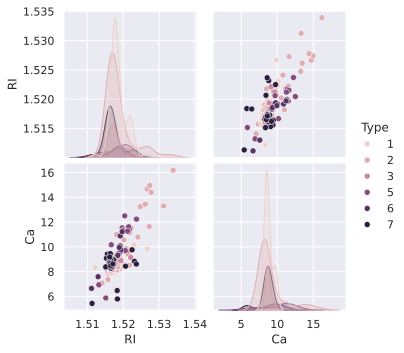

In [ ]:
# Create pairplot for 'RI', 'Ca', and 'Type'
sns.pairplot(glass, vars=['RI', 'Ca'], hue='Type');
plt.show()


Декілька точок знаходяться на краях розподілів, особливо для Ca вище 15. Це може бути особливий тип скла або аномальні дані.

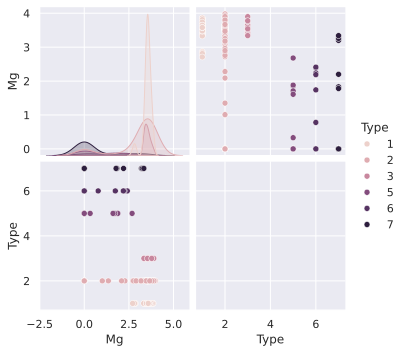

In [ ]:
# Create pairplot for 'MG' and 'Type'
sns.pairplot(glass, vars=['Mg', 'Type'], hue='Type');
plt.show()

Деякі категорії скла взагалі не містять Mg, тоді як інші мають помітну кількість.
Графік показує, що розподіл Mg є нерівномірним, і можна виділити дві групи: одна без Mg, інша – із його значним вмістом.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Experiment 1: With 'Ca' column
X_with_ca = glass.drop('Type', axis=1)
y = glass['Type']
X_train_with_ca, X_test_with_ca, y_train, y_test = train_test_split(X_with_ca, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_with_ca = scaler.fit_transform(X_train_with_ca)
X_test_with_ca = scaler.transform(X_test_with_ca)

model_with_ca = LogisticRegression(max_iter=1000)
model_with_ca.fit(X_train_with_ca, y_train)
y_pred_with_ca = model_with_ca.predict(X_test_with_ca)
accuracy_with_ca = accuracy_score(y_test, y_pred_with_ca)
print(f"Accuracy with 'Ca' column: {accuracy_with_ca}")


# Experiment 2: Without 'Ca' column
X_without_ca = glass.drop(['Type', 'Ca'], axis=1)
X_train_without_ca, X_test_without_ca, y_train, y_test = train_test_split(X_without_ca, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_without_ca = scaler.fit_transform(X_train_without_ca)
X_test_without_ca = scaler.transform(X_test_without_ca)

model_without_ca = LogisticRegression(max_iter=1000)
model_without_ca.fit(X_train_without_ca, y_train)
y_pred_without_ca = model_without_ca.predict(X_test_without_ca)
accuracy_without_ca = accuracy_score(y_test, y_pred_without_ca)
print(f"Accuracy without 'Ca' column: {accuracy_without_ca}")

# Compare results
if accuracy_with_ca > accuracy_without_ca:
    print("Keeping the 'Ca' column results in better accuracy.")
elif accuracy_with_ca < accuracy_without_ca:
    print("Removing the 'Ca' column results in better accuracy.")
else:
    print("Both options yield the same accuracy.")


Accuracy with 'Ca' column: 0.6976744186046512
Accuracy without 'Ca' column: 0.6976744186046512
Both options yield the same accuracy.


тест показав, що приберемо ми ca чи ні це не вплине

In [ ]:
!pip install featuretools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 25.1 MB/s eta 0:00:00


In [ ]:
import featuretools as ft
import pandas as pd

# Предполагаем, что DataFrame "glass" уже загружен и содержит уникальный индекс
if "Id" not in glass.columns:
    glass["Id"] = range(len(glass))  # Создаем индекс, если его нет

# Создаем EntitySet
es = ft.EntitySet(id="glass_data")

# Добавляем DataFrame "glass" в EntitySet (новый синтаксис)
es = es.add_dataframe(
    dataframe_name="glass",
    dataframe=glass,
    index="Id",  # Индексная колонка
    semantic_tags={"Type": "category"}  # Определяем категориальную переменную
)

# Определяем примитивы для генерации фичей
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="glass",
    max_depth=2,
    agg_primitives=["mean", "sum", "std", "min", "max"],  # Агрегирующие функции
    trans_primitives=["add_numeric", "multiply_numeric"],  # Трансформационные примитивы
    verbose=True
)

# Выводим первые строки сгенерированных фичей
print(feature_matrix.head())



/usr/local/lib/python3.11/dist-packages/featuretools/synthesis/deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/featuretools/synthesis/dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['max', 'mean', 'min', 'std', 'sum']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Built 100 features
Elapsed: 00:00 | Progress: 100%|██████████
         RI     Na    Mg    Al     Si     K    Ca   Ba    Fe  Type  ...  \
Id                                                                  ...   
0   1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.00     1  ...   
1   1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.00     1  ...   
2   1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.00     1  ...   
3   1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.00     1  ...   
4   1.51596  12.79  3.61  1.62  72.97  0.64  8.07  0.0  0.26     1  ...   

    Mg * Na   Mg * RI   Mg * Si  Mg * Type    Na * RI    Na * Si  Na * Type  \
Id                                                                            
0   50.0040  5.463396  261.8280       3.60  21.079603  1010.2197      13.89   
1   48.0315  5.382439  259.1145       3.55  20.513915   987.5547      13.53   
2   48.7449  5.600165  267.9309       3.69  20.048289   959.1781      13.21   
3   48.0374  5.49

In [ ]:
!pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 861.0 kB/s eta 0:00:00


In [ ]:
# Feature selection using Boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Prepare the data for Boruta
X = feature_matrix.drop("Type", axis=1)
y = feature_matrix["Type"]

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Define Boruta feature selector
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# Find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.values)

# Check selected features
print(feat_selector.support_)
print(feat_selector.ranking_)

# Get selected feature names
selected_features = X.columns[feat_selector.support_]

# Filter the feature matrix to keep only selected features
X_selected = X[selected_features]

# Now you can use X_selected with your machine learning model
print(f"Selected features: {selected_features}")


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	99
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	65
Tentative: 	16
Rejected: 	18
Iteration: 	9 / 100
Confirmed: 	65
Tentative: 	16
Rejected: 	18
Iteration: 	10 / 100
Confirmed: 	65
Tentative: 	16
Rejected: 	18
Iteration: 	11 / 100
Confirmed: 	65
Tentative: 	16
Rejected: 	18
Iteration: 	12 / 100
Confirmed: 	69
Tentative: 	12
Rejected: 	18
Iteration: 	13 / 100
Confirmed: 	69
Tentative: 	12
Rejected: 	18
Iteration: 	14 / 100
Confirmed: 	69
Tentative: 	12
Rejected: 	18
Iteration: 	15 / 100
Confirmed: 	69
Tentative: 	12
Rejected: 	18
Iteration: 	16 / 100
Confirmed: 	71
Tentative: 	

In [ ]:
# Get selected feature names
selected_features = X.columns[feat_selector.support_]

# Add selected features to the original glass DataFrame
glass_selected = pd.concat([glass, X_selected], axis=1)

# Now 'glass_selected' contains the original features and the selected features from featuretools
print(glass_selected.head())


        RI     Na    Mg    Al     Si     K    Ca   Ba    Fe  Type  ...  \
0  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.00     1  ...   
1  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.00     1  ...   
2  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.00     1  ...   
3  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.00     1  ...   
4  1.51596  12.79  3.61  1.62  72.97  0.64  8.07  0.0  0.26     1  ...   

   K * Type  Mg * Na   Mg * RI   Mg * Si  Mg * Type    Na * RI    Na * Si  \
0      0.48  50.0040  5.463396  261.8280       3.60  21.079603  1010.2197   
1      0.39  48.0315  5.382439  259.1145       3.55  20.513915   987.5547   
2      0.57  48.7449  5.600165  267.9309       3.69  20.048289   959.1781   
3      0.55  48.0374  5.493060  264.5496       3.62  20.136163   969.7716   
4      0.64  46.1719  5.472616  263.4217       3.61  19.389128   933.2863   

   Na * Type  RI * Type  Si * Type  
0      13.89    1.51761      72.73  
1      13.53    1.

In [ ]:
# Separate features (X) and target (y)
X = glass_selected.drop("Type", axis=1)
y = glass_selected["Type"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression on glass_selected: {accuracy}")


Accuracy of Logistic Regression on glass_selected: 0.9534883720930233


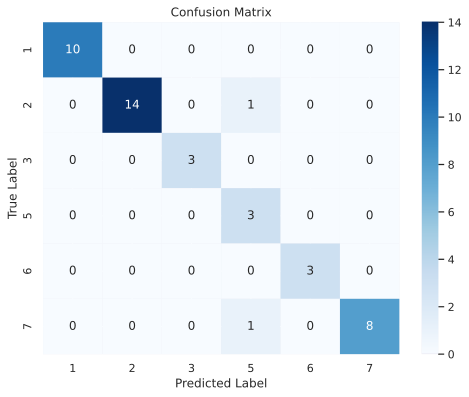

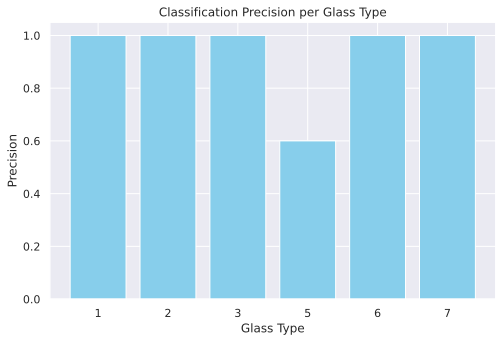

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Построим матрицу ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Получим отчет о классификации
report = classification_report(y_test, y_pred, output_dict=True)
class_accuracy = {key: report[key]['precision'] for key in report if key.isdigit()}

# Визуализируем точность по классам
plt.figure(figsize=(8, 5))
plt.bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
plt.xlabel("Glass Type")
plt.ylabel("Precision")
plt.title("Classification Precision per Glass Type")
plt.show()


ми додали нові фічі через фічетулс та прибрали дуже зайві через боруто, вийшла якась шалена акуратність моделі якщо пройтися по логістичній регресії 0.95. побудували графіки помилок і виявилося шо 5 клас де найчастіше помилки. 3  клас  17,
5   клас 13
6   клас  9, з ними теж попрацюємо щоб вирівняти кількість замірів


Results for SMOTE with Logistic Regression:
Accuracy: 0.9535
Precision: 0.9721
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00         3
           5       0.60      1.00      0.75         3
           6       1.00      1.00      1.00         3
           7       1.00      0.89      0.94         9

    accuracy                           0.95        43
   macro avg       0.93      0.97      0.94        43
weighted avg       0.97      0.95      0.96        43



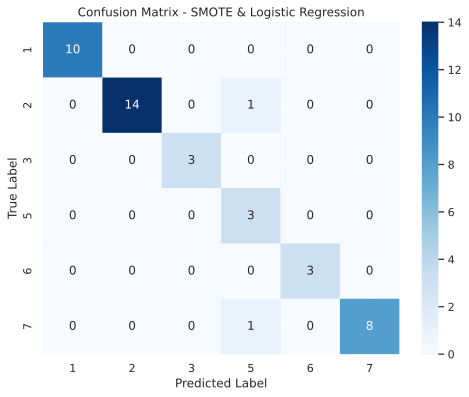


Results for SMOTE with XGBoost:
Accuracy: 0.9767
Precision: 0.9826
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         3
           7       1.00      0.89      0.94         9

    accuracy                           0.98        43
   macro avg       0.96      0.98      0.97        43
weighted avg       0.98      0.98      0.98        43



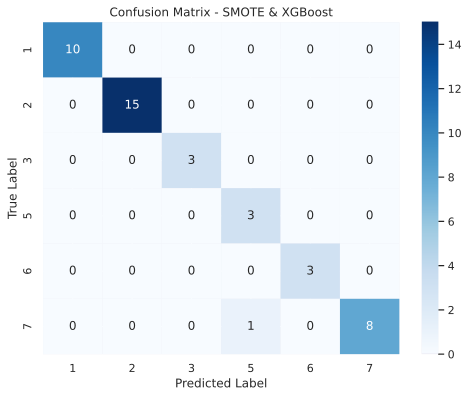


Results for SMOTE with SVC:
Accuracy: 0.9302
Precision: 0.9419
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.83      1.00      0.91        15
           3       1.00      1.00      1.00         3
           5       1.00      0.33      0.50         3
           6       1.00      1.00      1.00         3
           7       1.00      0.89      0.94         9

    accuracy                           0.93        43
   macro avg       0.97      0.87      0.89        43
weighted avg       0.94      0.93      0.92        43



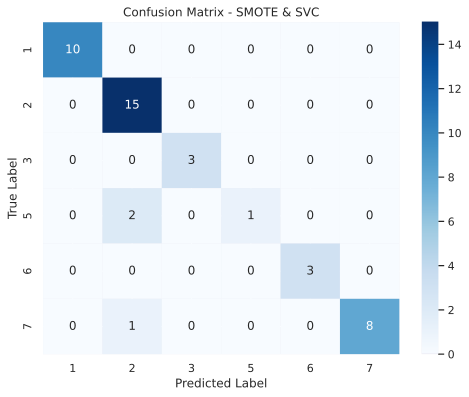


Results for SMOTE with RandomForestClassifier:
Accuracy: 1.0000
Precision: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         9

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



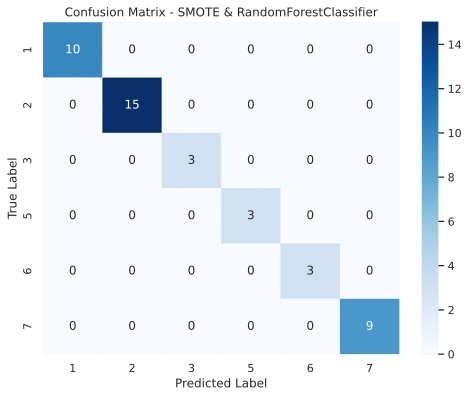


Results for RandomOverSampler with Logistic Regression:
Accuracy: 0.9535
Precision: 0.9721
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00         3
           5       0.60      1.00      0.75         3
           6       1.00      1.00      1.00         3
           7       1.00      0.89      0.94         9

    accuracy                           0.95        43
   macro avg       0.93      0.97      0.94        43
weighted avg       0.97      0.95      0.96        43



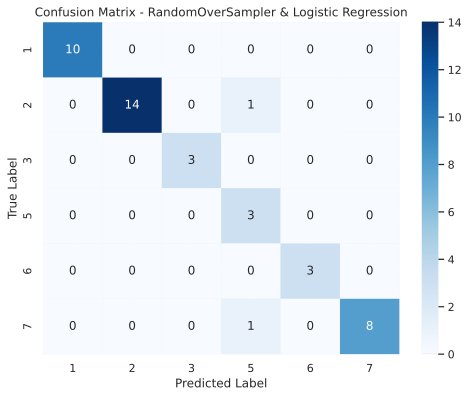


Results for RandomOverSampler with XGBoost:
Accuracy: 0.9535
Precision: 0.9614
Classification Report:
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        10
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         3
           7       1.00      0.89      0.94         9

    accuracy                           0.95        43
   macro avg       0.94      0.97      0.95        43
weighted avg       0.96      0.95      0.95        43



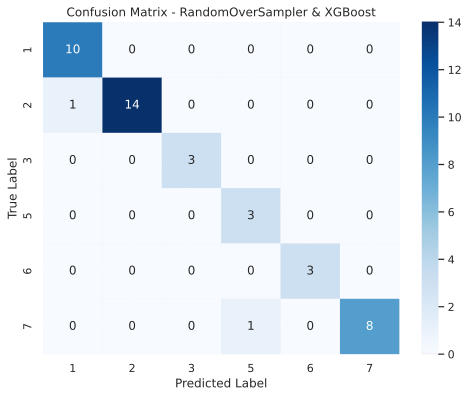


Results for RandomOverSampler with SVC:
Accuracy: 0.9302
Precision: 0.9419
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.83      1.00      0.91        15
           3       1.00      1.00      1.00         3
           5       1.00      0.33      0.50         3
           6       1.00      1.00      1.00         3
           7       1.00      0.89      0.94         9

    accuracy                           0.93        43
   macro avg       0.97      0.87      0.89        43
weighted avg       0.94      0.93      0.92        43



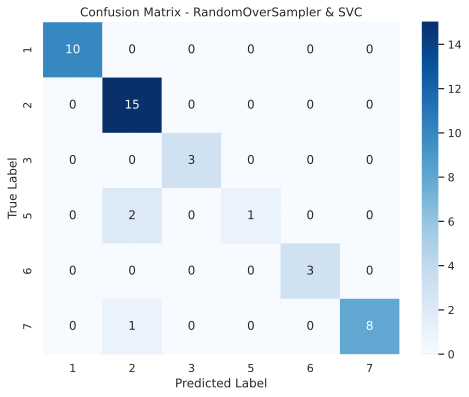


Results for RandomOverSampler with RandomForestClassifier:
Accuracy: 1.0000
Precision: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         9

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



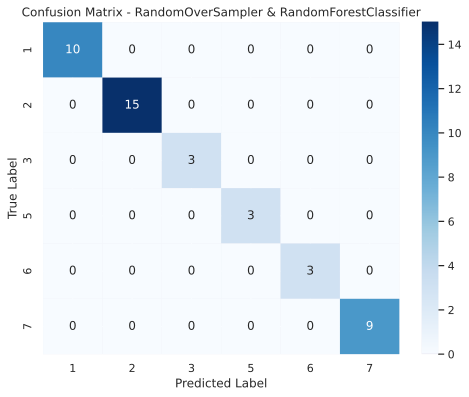


Results for SVMSMOTE with Logistic Regression:
Accuracy: 0.9535
Precision: 0.9721
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00         3
           5       0.60      1.00      0.75         3
           6       1.00      1.00      1.00         3
           7       1.00      0.89      0.94         9

    accuracy                           0.95        43
   macro avg       0.93      0.97      0.94        43
weighted avg       0.97      0.95      0.96        43



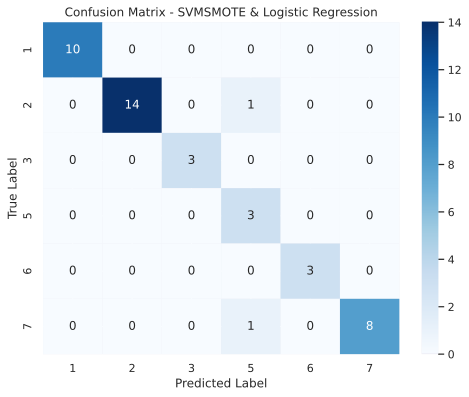


Results for SVMSMOTE with XGBoost:
Accuracy: 0.9535
Precision: 0.9614
Classification Report:
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        10
           2       1.00      0.87      0.93        15
           3       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         9

    accuracy                           0.95        43
   macro avg       0.94      0.98      0.96        43
weighted avg       0.96      0.95      0.95        43



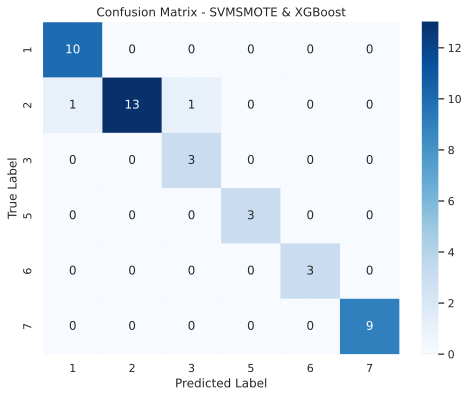


Results for SVMSMOTE with SVC:
Accuracy: 0.9302
Precision: 0.9271
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00         3
           5       0.50      0.33      0.40         3
           6       1.00      1.00      1.00         3
           7       0.82      1.00      0.90         9

    accuracy                           0.93        43
   macro avg       0.89      0.88      0.88        43
weighted avg       0.93      0.93      0.93        43



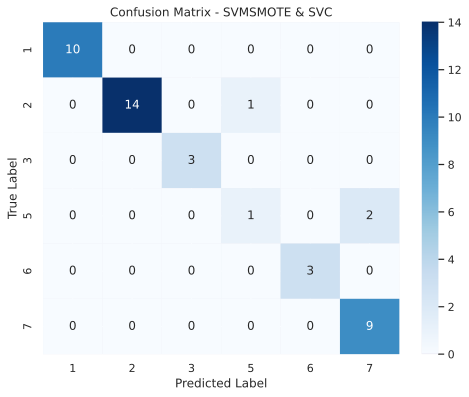


Results for SVMSMOTE with RandomForestClassifier:
Accuracy: 1.0000
Precision: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         9

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



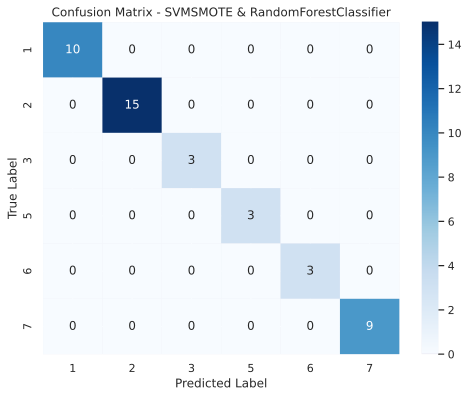

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler, SVMSMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Преобразование меток классов
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(glass_selected["Type"])  # Кодируем целевые метки

# Разделяем на признаки и целевую переменную
X = glass_selected.drop("Type", axis=1)

# Разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Определяем методы балансировки
sampling_methods = {
    "SMOTE": SMOTE(random_state=42),
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "SVMSMOTE": SVMSMOTE(random_state=42)
}

# Определяем модели
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(random_state=42),
    "SVC": SVC(),
    "RandomForestClassifier": RandomForestClassifier(random_state=42)
}

results = {}

# Обучаем модели с разными методами балансировки
for sampler_name, sampler in sampling_methods.items():
    results[sampler_name] = {}
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)  # Балансируем обучающий набор

    for model_name, model in models.items():
        model.fit(X_resampled, y_resampled)  # Обучение модели
        y_pred = model.predict(X_test)  # Предсказания на тесте

        # Обратное преобразование предсказаний
        y_pred = label_encoder.inverse_transform(y_pred)
        y_test_inv = label_encoder.inverse_transform(y_test)

        # Метрики
        accuracy = accuracy_score(y_test_inv, y_pred)
        precision = precision_score(y_test_inv, y_pred, average='weighted')
        report = classification_report(y_test_inv, y_pred, output_dict=True)

        results[sampler_name][model_name] = {
            "accuracy": accuracy,
            "precision": precision,
            "classification_report": report
        }

        # Вывод результатов
        print(f"\nResults for {sampler_name} with {model_name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Classification Report:\n{classification_report(y_test_inv, y_pred)}")

        # Построение матрицы ошибок
        conf_matrix = confusion_matrix(y_test_inv, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_test_inv), yticklabels=np.unique(y_test_inv))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix - {sampler_name} & {model_name}")
        plt.show()

In [ ]:
glass_selected.head()


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,...,K * Type,Mg * Na,Mg * RI,Mg * Si,Mg * Type,Na * RI,Na * Si,Na * Type,RI * Type,Si * Type
0,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1,...,0.48,50.0040,5.463396,261.8280,3.60,21.079603,1010.2197,13.89,1.51761,72.73
1,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1,...,0.39,48.0315,5.382439,259.1145,3.55,20.513915,987.5547,13.53,1.51618,72.99
2,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1,...,0.57,48.7449,5.600165,267.9309,3.69,20.048289,959.1781,13.21,1.51766,72.61
3,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1,...,0.55,48.0374,5.493060,264.5496,3.62,20.136163,969.7716,13.27,1.51742,73.08
4,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1,...,0.64,46.1719,5.472616,263.4217,3.61,19.389128,933.2863,12.79,1.51596,72.97


за матрицями помилок краще всього впоралися smsmote & randomforestclassifier, randomoversampler & randomforest, smote & randomforst
